# **Boston BLUE bikes Analysis**

Team Member: Zhangcheng Guo, Chang-Han Chen, Ziqi Shan, Tsung Yen Wu, Jiahui Xu

### Topic Background and Motivation
>A rapidly growing industry, bike-sharing, replaces traditional bike rentals. BLUE bikes' renting procedures are fully automated from picking up, returning, and making payments. With bike-sharing businesses like BLUE bikes, users can easily rent a bike from a particular position and return to another position without artificial interference. Currently, there are about over 500 bike-sharing programs around the world which are composed of over 2.3 million bicycles. In Boston, the BLUE bike has over 300 bike stations and 5000 bikes in service. With growing station coverage in Boston, BLUE bikes can bring more convenience and therefore, promote more usage.

>Moreover, BLUE bikes promote the action of 'Go Green', which has become a popular way of commuting in response to climate change. BLUE bikes' business model serves as a means of providing an option to Go Green, and promotes more physical activities. It also reduces the concern of stolen bikes for users, which is a common concern in Boston.



### Project Objective
>With good causes of BLUE bikes, it incentivses us more to learn more about the bussiness, and align our objective with BLUE bike's cause. We aim to help maximize bike trips for BLUE bikes to provide a healthier and more eco freindly way of commuting by looking more indepth into potential variables that affect trip volume.

### Dataset Information and Processing

#### Data Profile
>'BLuebikes trip data' contains monthly bike trip data, and includes: 
>
>- Trip Duration (seconds)
- Start Time and Date
- Stop Time and Date
- Start Station Name & ID
- End Station Name & ID
- Bike ID
- User Type (Casual = Single Trip or Day Pass user; Member = Annual or Monthly Member)
- Birth Year
- Gender, self-reported by capital (0=unknown; 1=male; 2=female)
>
> 
>
>In addition to Bluebikes's data, weather information from NOAA is merged into original dataset considering impact of weather on bike rentals.
- TAVG - average temperature for the day (in whole degrees Fahrenheit). This is based on the arithmetic average of the maximum and minimum temperature for the day.
- SNOW - daily amount of snowfall (in inches to the tenths)
- AWND - average wind speed in miles per hour miles per hour, to tenths)
- PRCP - precipitation (in inches to the tenths)
>
>
>Two new columns listed are added to gain further infomation on each station
- District
- Total Docks (of each stations)

#### Dataset Source
>Bluebikes Trip Data, current_bluebikes_stations: https://s3.amazonaws.com/hubway-data/index.html
>
>NOAA Boston 2019 Weather Datase: <https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00014739/detail>

#### Raw Datasets
Here are sneakpeaks of datasets. Please note that our datasets are stored in private google drive. To request access, please email kguo@bu.edu. No commercial use allowed.





In [180]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [181]:
## Sneakpeak of BLUEbikes dataset
blueraw = pd.read_csv('/content/drive/Shareddrives/MSBA BA 775 Team 1/Bluebikes/bb2019.csv',index_col=0);
blueraw.head(3)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Date
0,371,2019-01-01 00:09:13.798,2019-01-01 00:15:25.336,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179,MIT Vassar St,42.355601,-71.103945,3689,Subscriber,1987,1,2019-01-01
1,264,2019-01-01 00:33:56.182,2019-01-01 00:38:20.880,117,Binney St / Sixth St,42.366162,-71.086883,189,Kendall T,42.362428,-71.084955,4142,Subscriber,1990,1,2019-01-01
2,458,2019-01-01 00:41:54.600,2019-01-01 00:49:33.273,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,1628,Subscriber,1977,1,2019-01-01


In [182]:
## Sneakpeak of NOAA Boston weather dataset
bosweather = pd.read_csv('/content/drive/Shareddrives/MSBA BA 775 Team 1/Bluebikes/BosWeather19.csv',index_col=0);
bosweather.head(3)

,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,PRCP,SNOW,SNWD,TAVG,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
STATION,,,,,,,,,,,,,,,,,,
USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2019-01-01,15.88,0.38,0.0,NaN,47,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2019-01-02,9.40,0.00,0.0,NaN,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
USW00014739,"BOSTON, MA US",42.3606,-71.0097,3.7,2019-01-03,10.51,0.02,0.0,NaN,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
## Sneakpeak of distrcit&docks dataset
bikestations=pd.read_csv('/content/drive/Shareddrives/MSBA BA 775 Team 1/Bluebikes/current_bluebikes_stations.csv',index_col=0,header = 1)
bikestations.head(3)

,Name,Latitude,Longitude,District,Public,Total docks
Number,,,,,,
A32019,175 N Harvard St,42.363796,-71.129164,Boston,Yes,18
S32035,191 Beacon St,42.380323,-71.108786,Somerville,Yes,19
S32023,30 Dane St,42.381001,-71.104025,Somerville,Yes,15


#### Data Preprocessing

'blueraw' dataset contains some null cells, which is processed and modified as following:

- 'age':

  'age' column is created and calculated from [today's year - birthyear] for better visualization. Some cells record user age higher than 80 years old, which is suspected to be the user's manual input error. Therefore, ages over 80 years old are replaced by age median 31 to eliminate outliers but not affecting age distribution. 

- 'bikeid':

  bikeid column is converted from int64 to str to be treated as categorical variable.

- 'gender':

  Gender columns, originally recorded as 0,1,2 are changed into 'U' (unknown), 'M' (male) and 'F' (female) to be easier treated as categorical variables.

- 'Holiday':

  'Holiday' is created from starttime infomation to record whether it is weekend,Federal holidays or workdays , 1 for yes, 0 for no.

- 'District' and 'End District':

  Two columns contain some missing District cells after merged with 'bike stations'. This is due to the 'bike stations' dataset recording the latest stations, while'blueraw 'dataset records the trip that occurred in 2019. With the rapid growth of the BLUE bikes business, some stations are removed or added between 2019 and now.
With those stations that can be found on Bluebikes, District names are manually added. 
Rows with columns start and end station recorded 'Mobile Temporary Station' and 'Warehouse Bonfire Station in a Box', 'MTL-ECO4-01', 'Warehouse Lab PBSC' is removed (83 rows).

'blueraw' is then merged with 'bosweather' and 'bikestations', and recorded as 'Blue19', the main dataset, shown below.


In [184]:
Blue19=pd.read_csv('/content/drive/Shareddrives/MSBA BA 775 Team 1/Bluebikes/Blue19.csv',index_col=0);
Blue19['starttime'] =  pd.to_datetime(Blue19['starttime']) ##Convert time variable to datetime
Blue19['stoptime'] =  pd.to_datetime(Blue19['stoptime'])
Blue19['Date'] = pd.to_datetime(Blue19['Date'])
Blue19.head(3)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,Date,Holiday,AWND,PRCP,SNOW,TAVG,age,District,month,season,End District
0,371,2019-01-01 00:09:13.798,2019-01-01 00:15:25.336,80,MIT Stata Center at Vassar St / Main St,42.362131,-71.091156,179,MIT Vassar St,42.355601,-71.103945,3689,Subscriber,1987,M,2019-01-01,1,15.88,0.38,0.0,47,33,Cambridge,1,winter,Cambridge
1,264,2019-01-01 00:33:56.182,2019-01-01 00:38:20.880,117,Binney St / Sixth St,42.366162,-71.086883,189,Kendall T,42.362428,-71.084955,4142,Subscriber,1990,M,2019-01-01,1,15.88,0.38,0.0,47,30,Cambridge,1,winter,Cambridge
2,458,2019-01-01 00:41:54.600,2019-01-01 00:49:33.273,68,Central Square at Mass Ave / Essex St,42.365070,-71.103100,96,Cambridge Main Library at Broadway / Trowbridg...,42.373379,-71.111075,1628,Subscriber,1977,M,2019-01-01,1,15.88,0.38,0.0,47,43,Cambridge,1,winter,Cambridge


In [186]:
Blue19.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2522494 entries, 0 to 2522493
Data columns (total 26 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int64         
 1   starttime                datetime64[ns]
 2   stoptime                 datetime64[ns]
 3   start station id         int64         
 4   start station name       object        
 5   start station latitude   float64       
 6   start station longitude  float64       
 7   end station id           int64         
 8   end station name         object        
 9   end station latitude     float64       
 10  end station longitude    float64       
 11  bikeid                   int64         
 12  usertype                 object        
 13  birth year               int64         
 14  gender                   object        
 15  Date                     datetime64[ns]
 16  Holiday                  int64         
 17  AWND                     fl

In [188]:
# check missing data
Blue19.dropna(how= 'any', inplace =True) ## delete cells that are na, 83 rows of empty district names
pd.isnull(Blue19).sum()

tripduration               0
starttime                  0
stoptime                   0
start station id           0
start station name         0
start station latitude     0
start station longitude    0
end station id             0
end station name           0
end station latitude       0
end station longitude      0
bikeid                     0
usertype                   0
birth year                 0
gender                     0
Date                       0
Holiday                    0
AWND                       0
PRCP                       0
SNOW                       0
TAVG                       0
age                        0
District                   0
month                      0
season                     0
End District               0
dtype: int64

### Data Behavior

##### **User Demographics**

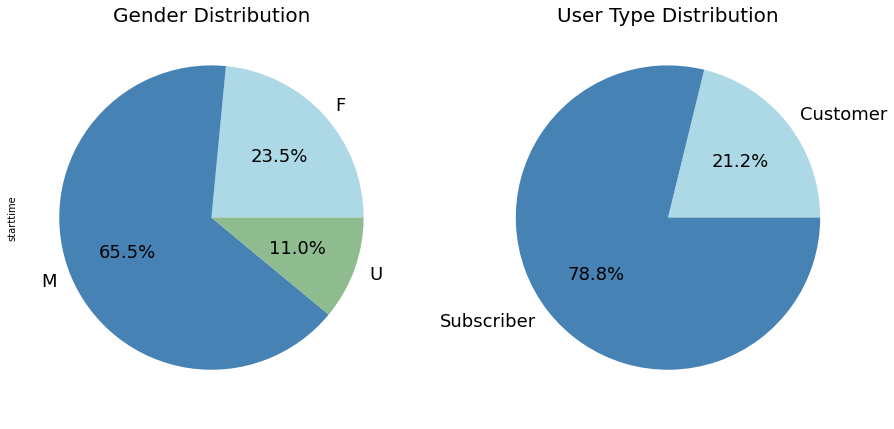

In [ ]:
genderdis = Blue19.groupby('gender').count()['starttime']  ##age distribution
userdis = Blue19.groupby('usertype').count()['starttime']  ##User Type Distribution
fig, axis = plt.subplots(1, 2, figsize=(15,7))
plt.ylabel('')
axis[0].set_title("Gender Distribution",fontsize = 20)
axis[1].set_title("User Type Distribution",fontsize = 20)
colors=['lightblue','steelblue','darkseagreen']

ax = genderdis.plot.pie(autopct="%.1f%%", ax = axis[0],colors=colors,fontsize = 18);
ax = userdis.plot.pie(autopct="%.1f%%", ax = axis[1],colors=colors, fontsize = 18);
plt.xlabel(' ');
plt.ylabel(' ');

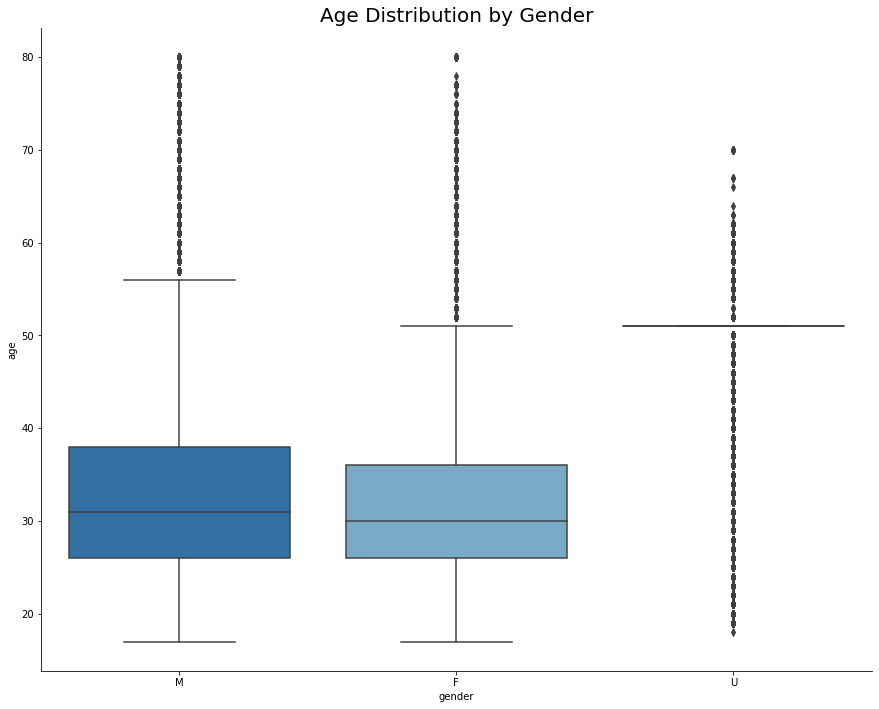

In [189]:
mkt= Blue19[['bikeid','usertype', 'age', 'gender']]
pd.DataFrame(mkt['age'].agg({'mean','median','std'}))
 
g=sns.catplot(data=mkt,x='gender',y='age',kind='box',aspect=3,palette='Blues_r');
plt.title('Age Distribution by Gender', fontsize= 20);
g.fig.set_figwidth(12)
g.fig.set_figheight(10)

*   As shown above, more than half of the users are male which is 65.15%, and subscribers take up 78.83% of user composition.
The average age is 35 years old and the median is 31 with a standard deviation of 11.55. If divided the users into subscribers and non-subscribers, the subscribers are around 34 years old on average, whereas the non-subscribers are 41 years old on average. The difference in age between male and female is not significant, as male is around 34 years old on average and female is around 33 years old on average.


#### **Time Variables**

> *   The goal is to know if there are more trips on weekdays or on weekends. To do this, we counted the average trip counts in each day of week. The result shows that on average, it is between 7,000 to 7,500 trip counts from Monday to Friday (on weekdays), while it is roughly 6,000 when it comes to Saturday and Sunday (on weekends). It seems that BLUEbikes are more popular on weekdays than on weekends.
*   In addition, the average usage times are longer on weekends than on weekways. On weekdays, a user spends around 15 to 17 minutes on BLUEbikes on average, while on weekends, a user spends roughly 22 to 23 minutes on BLUEbikes on average. This phenomenon may be explained that there are more commuters on weekdays that they choose BLUEbikes for short distances in high flexibility. For example, for commuters who take the subway for work/school, they may choose BLUEbikes to connect between subway station to the place they work for/study at. So, the travelled distances and durations of the BLUEbikes on weekdays could be rather short.On weekends, however, there are probably more recreational uses on BLUEbikes such as riding bikes along the coast and that encourages users to utilize BLUEbikes regardless of how much time spent.

###### Data Processing

In [190]:
blue19_dur = Blue19[['tripduration', 'starttime', 'stoptime', 'Date']]
blue19_dur['starttime'] = pd.to_datetime(blue19_dur['starttime']);
blue19_dur['stoptime'] = pd.to_datetime(blue19_dur['stoptime']);
blue19_dur['Date'] = pd.to_datetime(blue19_dur['Date']);
blue19_dur['duration_manual'] = (blue19_dur['stoptime'] - blue19_dur['starttime']).astype('timedelta64[s]')
blue19_dur[blue19_dur['tripduration'] != blue19_dur['duration_manual']].count()
blue19_dur_diff = blue19_dur[blue19_dur['tripduration'] != blue19_dur['duration_manual']]
(blue19_dur_diff['duration_manual'] - blue19_dur_diff['tripduration']).value_counts()
blue19_dur.loc[Blue19['tripduration'] != blue19_dur['duration_manual'], 'Date'].unique().astype('datetime64[D]');
blue19_dur_clean = blue19_dur[(blue19_dur['tripduration'] == blue19_dur['duration_manual']) & (blue19_dur['tripduration'] <= 86400)]
blue19_dur_clean['start_dayofweek'] = blue19_dur_clean['starttime'].dt.dayofweek
blue19_dur_clean['start_hour'] = blue19_dur_clean['starttime'].dt.hour

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
blue19_dur_clean.groupby('start_dayofweek')['tripduration'].count()/blue19_dur_clean.groupby('start_dayofweek')['Date'].nunique();
blue19_dur_clean.groupby('start_dayofweek')['tripduration'].mean();
dw_hr_count = (blue19_dur_clean.groupby(['start_dayofweek', 'start_hour'])['tripduration'].count()/blue19_dur_clean.groupby(['start_dayofweek', 'start_hour'])['Date'].nunique()).reset_index(name = 'trip_count').sort_values('trip_count', ascending = False)
print(dw_hr_count.head(10))

     start_dayofweek  start_hour  trip_count
41                 1          17  962.660377
65                 2          17  921.403846
17                 0          17  920.865385
89                 3          17  919.884615
56                 2           8  889.057692
32                 1           8  837.698113
113                4          17  813.442308
80                 3           8  812.423077
104                4           8  787.134615
8                  0           8  785.096154


###### **Hourly behavior**


*   Longer trip at midnight
*   Users spend less time at early mornings on weekdays
*   The average trip duration is about 26 minutes = 1560 seconds

In [191]:
blue19_dur_clean.groupby(['start_dayofweek', 'start_hour'])['tripduration'].mean().reset_index().sort_values('tripduration', ascending = False).head(10)

,start_dayofweek,start_hour,tripduration
27,1,3,1979.222222
146,6,2,1844.769599
147,6,3,1700.134100
26,1,2,1696.435754
122,5,2,1641.406504
123,5,3,1636.529040
50,2,2,1620.211149
134,5,14,1555.282115
158,6,14,1551.208311
148,6,4,1546.418860


In [192]:
dw_hr_duration = blue19_dur_clean.groupby(['start_dayofweek', 'start_hour'])['tripduration'].mean().reset_index().sort_values('tripduration', ascending = True)
print(dw_hr_duration.head(10))

     start_dayofweek  start_hour  tripduration
53                 2           5    728.655410
102                4           6    731.744653
54                 2           6    746.228168
77                 3           5    747.767857
30                 1           6    751.608747
78                 3           6    753.177182
6                  0           6    754.685765
79                 3           7    777.788809
29                 1           5    779.780339
103                4           7    783.310056


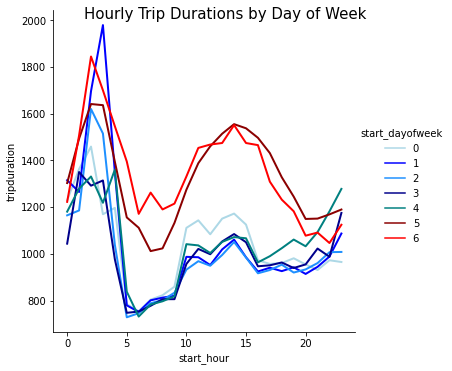

In [193]:
dw_hr_duration['start_dayofweek'] = dw_hr_duration['start_dayofweek'].astype('category')
sns.relplot(x = 'start_hour', y = 'tripduration', data = dw_hr_duration, hue = 'start_dayofweek', kind = 'line',linewidth = 2,  palette=['lightblue','blue','dodgerblue','darkblue','teal','darkred','red']).fig.suptitle('Hourly Trip Durations by Day of Week',fontsize = 15);

###### **Weekly behavior**

*   More popular on weedays than on weekends
*   Average useage times are longer on weekends
*   8 am and 5 pm are the most popular   

Note that the dt.dayofweek: <br><br/>
0: Monday; 1: Tuesday; 2: Wednesday; 3: Thursday; 4: Friday; 5: Saturday; 6: Sunday

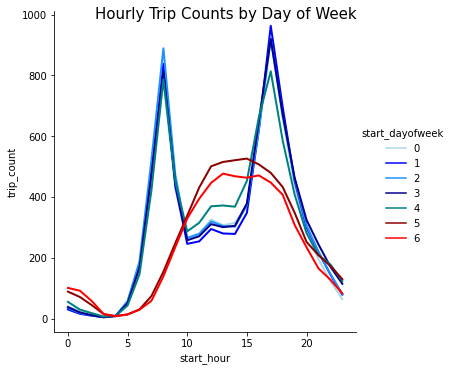

In [194]:
dw_hr_count['start_dayofweek'] = dw_hr_count['start_dayofweek'].astype('category')
sns.relplot(x = 'start_hour', y = 'trip_count', data = dw_hr_count, hue = 'start_dayofweek', kind = 'line',  palette=['lightblue','blue','dodgerblue','darkblue','teal','darkred','red'], linewidth = 2).fig.suptitle('Hourly Trip Counts by Day of Week',fontsize = 15);

###### **Holiday**



*   Less rides on holidays
*   People prefer riding on working day




In [195]:
# with_cnt: table with a new column called 'count', which represent the daily total count
# new: table that only contain 'date', 'count', 'season', 'Holiday'
with_cnt=pd.read_csv('/content/drive/Shareddrives/MSBA BA 775 Team 1/Bluebikes/with_cnt.csv',index_col=0)
new=pd.read_csv('/content/drive/Shareddrives/MSBA BA 775 Team 1/Bluebikes/new.csv',index_col=0)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [196]:
holiday=with_cnt.groupby('Holiday')[['count']].mean()
holiday.rename(columns={'count':'count_mean'},inplace=True)
holiday=holiday.reset_index()
holiday

,Holiday,count_mean
0,0,9309.510965
1,1,7910.517173


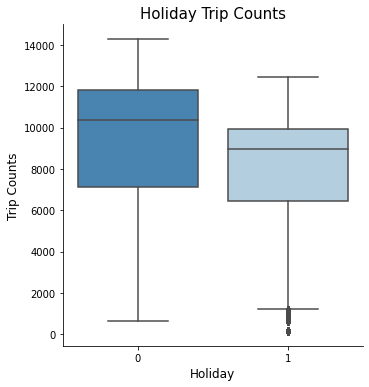

In [197]:
sns.catplot(x='Holiday',y='count', data=with_cnt, kind='box',palette='Blues_r' )
plt.title('Holiday Trip Counts', fontsize=15)
plt.xlabel("Holiday",fontsize=12);
plt.ylabel("Trip Counts",fontsize=12);

###### **Monthly**



*   More bike using in Sep, Aug and July
*   Seasonal pattern




In [198]:
month=new.groupby('month')[['count']].sum()
month=month.reset_index().sort_values(by='count',ascending=False)
month['percentage']=round(month['count']/with_cnt.shape[0]*100,2)
month['mean']=round(month['count']/30,2)
month

,month,count,percentage,mean
8,9,363185,14.40,12106.17
7,8,337443,13.38,11248.10
6,7,316931,12.56,10564.37
9,10,305504,12.11,10183.47
5,6,274022,10.86,9134.07
4,5,223084,8.84,7436.13
10,11,190759,7.56,6358.63
3,4,166694,6.61,5556.47
2,3,102369,4.06,3412.30
11,12,92208,3.66,3073.60


Text(-8.825000000000003, 0.5, 'mean count')

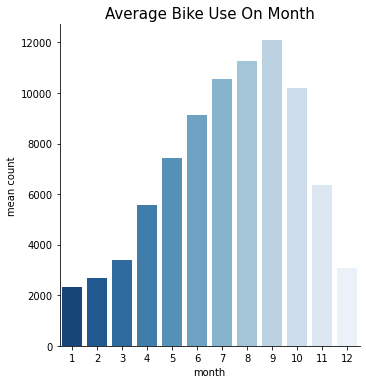

In [199]:
sns.catplot(x='month',y='mean', data=month, kind='bar',ci=None,palette = 'Blues_r')
plt.title('Average Bike Use On Month', fontsize=15)
plt.ylabel('mean count')

###### **Season**



*   More bike using in Summer and Autumn
Good weather and more opportunities 




In [200]:
season=new.groupby('season').agg({'count':['sum','mean']})
season=season.reset_index()
season

season   count              
              sum          mean
0  autumn  859448   9444.483516
1  spring  492147   5349.423913
2  summer  928396  10091.260870
3  winter  242546   2725.235955

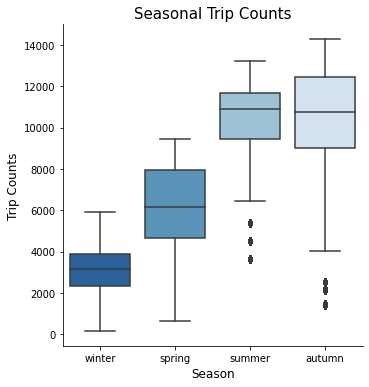

In [201]:
sns.catplot(x='season',y='count', data=with_cnt,kind='box', palette='Blues_r');
plt.title('Seasonal Trip Counts', fontsize= 15);
plt.xlabel("Season",fontsize=12);
plt.ylabel("Trip Counts",fontsize=12);

##### **Weather**

To observe relationship between trip counts and affect of weather such as wind, rain, snow and temperature, two axises plots are created for each category to visually see the relationships.

In [202]:
aggweather = {'tripduration':'count','AWND':'mean','PRCP':'mean',	'SNOW':'mean',	'TAVG':'mean'}
weathercount =Blue19.resample('M', on = 'starttime').agg(aggweather).reset_index()
weathercount = weathercount.rename(columns = {'starttime':'month','tripduration':'count'})

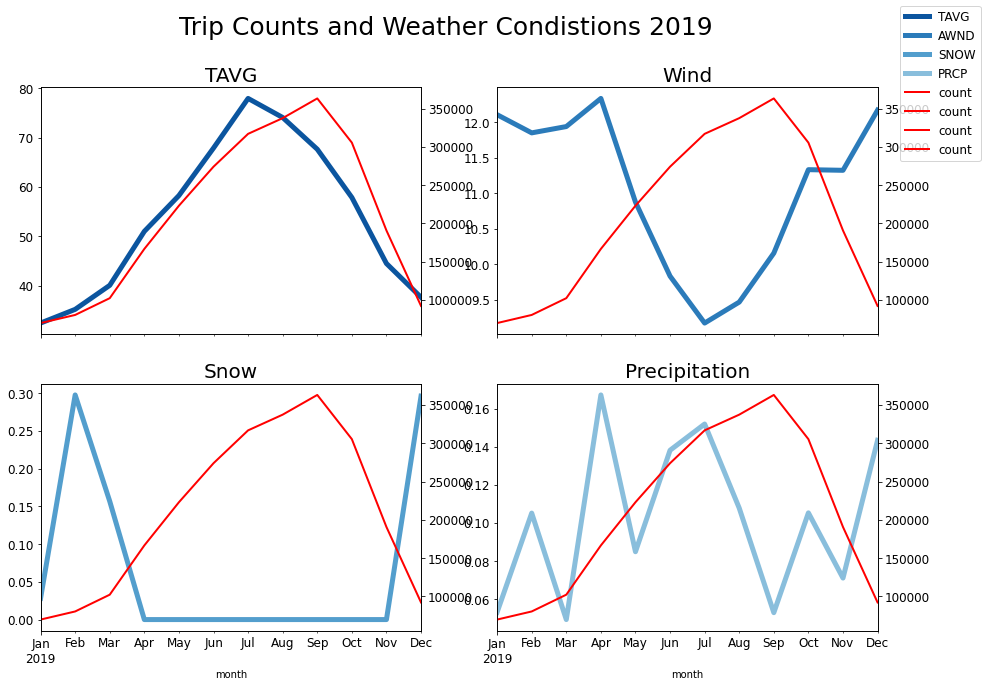

In [205]:
fig, axis = plt.subplots(2, 2, figsize=(15,10))
axis[0][0].set_title("TAVG",fontsize = 20)
axis[0][1].set_title("Wind",fontsize = 20)
axis[1][0].set_title("Snow",fontsize = 20)
axis[1][1].set_title("Precipitation",fontsize = 20)
fig.suptitle('Trip Counts and Weather Condistions 2019', fontsize = 25) 
evenly_spaced_interval = np.linspace(0, 1, 8)
colors = [plt.cm.Blues_r(x) for x in evenly_spaced_interval]

ax = weathercount.plot(x = 'month' , y = 'TAVG',legend = False, ax =axis [0][0],linewidth = 5,fontsize = 12,color = colors[1])
ax2 = ax.twinx()
weathercount.plot(x="month", y="count", ax=ax2,legend = False, color="r",linewidth = 2,fontsize = 12)
axa = weathercount.plot(x = 'month' , y = 'AWND',legend = False, ax =axis [0][1],linewidth = 5,fontsize = 12,color = colors[2])
ax2 = axa.twinx()
weathercount.plot(x="month", y="count", ax=ax2,legend = False, color="r",linewidth = 2,fontsize = 12)
axb = weathercount.plot(x = 'month' , y = 'SNOW',legend = False, ax =axis [1][0],linewidth = 5,fontsize = 12,color = colors[3])
ax2 = axb.twinx()
weathercount.plot(x="month", y="count", ax=ax2,legend = False, color="r",linewidth = 2,fontsize = 12)
axc = weathercount.plot(x = 'month' , y = 'PRCP',legend = False, ax =axis [1][1],linewidth = 5,fontsize = 12,color = colors[4])
ax2 = axc.twinx()
weathercount.plot(x="month", y="count", ax=ax2,legend = False,  color="r",linewidth = 2,fontsize = 12)
ax.figure.legend(fontsize = 12);

From the graph presented above, it is very clear to observe that high temperature on average occurs higher bike rentals than lower temperature. Inverse to snowfall, when more snow, there are fewer bike trips. The same trend applies to average wind speed, in which the wind speed in Boston is observed to be seasonal, higher in winter months, and lower in summer months.
It is reasonable to state that temperature, snowfall, and wind speed are seasonal, which later in the analysis. The seasonal factor can be considered in predicting the number of bike rentals.
As for precipitation, it is not very clear from the whole year observation; therefore a monthly line plot is performed to observe closer the relationship between precipitation and trip counts.

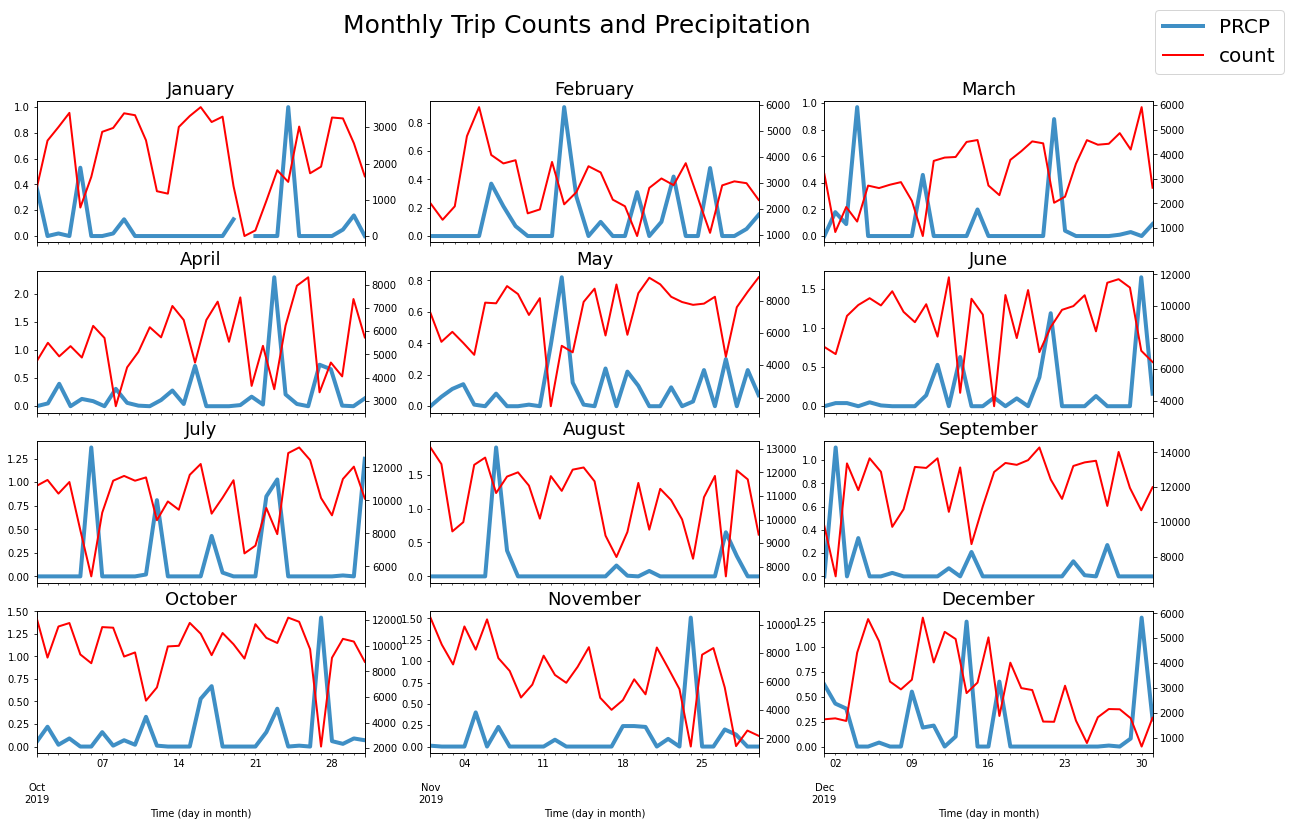

In [204]:
import datetime
import calendar

aggprcp = {'tripduration':'count','PRCP':'mean'}
prcpcount = Blue19.resample('D', on = 'starttime').agg(aggprcp).reset_index()
prcpcount['monthcat'] = pd.DatetimeIndex(prcpcount['starttime']).month
prcpcount = prcpcount.rename(columns = {'tripduration':'count'})
evenly_spaced_interval = np.linspace(0, 1, 12)
colors = [plt.cm.Blues_r(x) for x in evenly_spaced_interval]
fig, axis = plt.subplots(4, 3, figsize=(20,12))
axis = axis.ravel()
fig.suptitle('Monthly Trip Counts and Precipitation', fontsize = 25) 

for i in prcpcount['monthcat'].unique():
  prcp = prcpcount[prcpcount['monthcat'] == i]
  ax = prcp.plot(x = 'starttime' , y = 'PRCP',legend =False, ax =axis [i-1],color = colors[4], linewidth = 4);
  ax.set(xlabel = 'Time (day in month)')
  ax2 = ax.twinx()
  prcp.plot(x="starttime", y="count", ax=ax2,  color="r",legend =False, linewidth = 2);
  axis[i-1].set_title(calendar.month_name[i],fontsize = 18)

handles, labels = ax.get_legend_handles_labels()  
lgd = dict(zip(labels, handles))
handles2, labels2 = ax2.get_legend_handles_labels()  
lgd[labels2[0]] = handles2[0]
ax.figure.legend(lgd.values(), lgd.keys(), fontsize =20);

From the plots above, it is apparent that when the blue line peaks, the red line drops. In other words, when higher rainfall is observed, trip counts decrease accordingly. Though a direct relationship cannot be assumed, it is rational to state that whether raining or not is a factor affecting Bluebike renting. 

#### **Location**

To observe the relationship between trip counts and location. 
Start station, end station, and bike docks data were extracted to analyze. 


###### Data Processing

In [ ]:
stations = pd.read_csv('/content/drive/Shareddrives/MSBA BA 775 Team 1/Bluebikes/current_bluebikes_stations.csv',index_col=0,skiprows=1);
popular_start=Blue19.loc[:,['start station name']].value_counts(ascending =False).to_frame().reset_index()
popular_start.columns = [ 'start station name', 'trip counts']
popular_end=Blue19.loc[:,['end station name']].value_counts(ascending = False).to_frame().reset_index()
popular_end.columns = [ 'end station name', 'trip counts']
start_docks=popular_start.merge(stations, left_on = 'start station name', right_on = 'Name', how = 'left')
start_docks =start_docks[['start station name', 'trip counts','Total docks']]

end_docks=popular_end.merge(stations, left_on = 'end station name', right_on = 'Name', how = 'left')
end_docks =end_docks[['end station name', 'trip counts','Total docks']]


,end station name,trip counts,Total docks
0,MIT at Mass Ave / Amherst St,56986,27.0
1,Central Square at Mass Ave / Essex St,51442,19.0
2,Ames St at Main St,46293,19.0
3,Nashua Street at Red Auerbach Way,46243,37.0
4,MIT Stata Center at Vassar St / Main St,41828,35.0


In [178]:
#### District Dock Count
districtdock = bikestations.groupby('District').sum().reset_index().sort_values(by = 'Total docks',ascending =False)
districtdock = districtdock[['District','Total docks']]
#### District Trip Count
districtct = Blue19.groupby('District').count().reset_index().sort_values(by = 'starttime',ascending =False)
districtct.rename({'age':'Trip Count'}, axis = 1, inplace = True)
districtct = districtct[['District', 'Trip Count']]
#### District Station Count
station_count=Blue19.pivot_table(values='start station name', index=['District'], aggfunc=pd.Series.nunique)
#### Merged Table
disbar = districtct.merge(station_count, how = 'left', on ='District')
disbar.rename({'start station name': 'Station Count'}, axis = 1, inplace = True)
disbar =disbar.merge(districtdock, how = 'left', on = 'District')
disbar

,District,Trip Count,Station Count,Total docks
0,Boston,1423822,233,3918
1,Cambridge,878939,67,1338
2,Somerville,139095,30,493
3,Brookline,75677,14,191
4,Everett,4961,8,170


###### District Infomation

In [206]:
disbar

,District,Trip Count,Station Count,Total docks
0,Boston,1423822,233,3918
1,Cambridge,878939,67,1338
2,Somerville,139095,30,493
3,Brookline,75677,14,191
4,Everett,4961,8,170


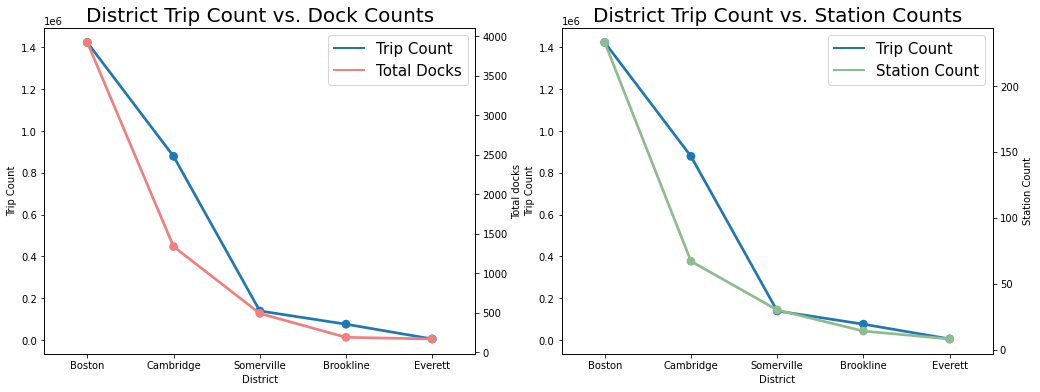

In [210]:
from matplotlib.lines import Line2D
fig, axis = plt.subplots(1, 2, figsize=(17,6))
axis[0].set_title("District Trip Count vs. Dock Counts",fontsize = 20)
axis[1].set_title("District Trip Count vs. Station Counts",fontsize = 20)

ax = sns.pointplot(x ='District', y='Trip Count' ,data=disbar, ax=axis[0])
ax2 = ax.twinx()
ax =sns.pointplot( x ='District', y='Total docks', data=disbar, ax = ax2, color = 'lightcoral')
custom_lines = [Line2D([0], [0],  lw=2),
                Line2D([0], [0], color='lightcoral', lw=2)]
ax.legend(custom_lines, ['Trip Count', 'Total Docks'],fontsize = 15);


axa = sns.pointplot(x ='District', y='Trip Count' ,data=disbar,ax=axis[1])
ax2 = axa.twinx()
axb =sns.pointplot( x ='District', y='Station Count', data=disbar, ax = ax2, color = 'darkseagreen')
custom_lines = [Line2D([0], [0],  lw=2),
                Line2D([0], [0], color='darkseagreen', lw=2)]
axb.legend(custom_lines, ['Trip Count', 'Station Count'],fontsize = 15);

> By observing two point plots of dock counts and station counts compared to trip counts. It can be observed that both trends almost align except Cambridge exhbits a dip compared to demand, which can potentially result in short of supply due to shortages in bikes.

###### Station Infomation

In [ ]:
start_docks=popular_start.merge(stations, left_on = 'start station name', right_on = 'Name', how = 'left')
start_docks =start_docks[['start station name', 'trip counts','Total docks']]
start_docks.head()

,start station name,trip counts,Total docks
0,MIT at Mass Ave / Amherst St,61056,27.0
1,Central Square at Mass Ave / Essex St,50996,19.0
2,MIT Stata Center at Vassar St / Main St,47197,35.0
3,South Station - 700 Atlantic Ave,44423,47.0
4,Ames St at Main St,39128,19.0


In [ ]:
end_docks=popular_end.merge(stations, left_on = 'end station name', right_on = 'Name', how = 'left')
end_docks =end_docks[['end station name', 'trip counts','Total docks']]
end_docks.head()

,end station name,trip counts,Total docks
0,MIT at Mass Ave / Amherst St,56986,27.0
1,Central Square at Mass Ave / Essex St,51442,19.0
2,Ames St at Main St,46293,19.0
3,Nashua Street at Red Auerbach Way,46243,37.0
4,MIT Stata Center at Vassar St / Main St,41828,35.0


> Boston and Cambridge have the highest trip counts if we group by the district. From the charts and the comparison between the number of docks in the starting station and the end station and their trip counts, the dock number of the starting station and the end station with the highest frequency do not align. Therefore, it can be concluded that more trip counts come with more bike docks, which is also proper to match both factors along with its geographic locations to optimize profit for BLUEbikes.

####  **Correlation Matrix**

*  Season and average temperature are highly correlated with daily count
*  Choose features with absolute scores > 0.15 to put in our model

In [ ]:
cor_table= pd.read_csv('/content/drive/Shareddrives/MSBA BA 775 Team 1/Bluebikes/cor_table.csv', index_col=0)
a=cor_table.copy()
dic={'winter':0, 'spring':1,'summer':2,'autumn':3, 'Subscriber':1, 'Customer':0,'Cambridge':0, 'Boston':1, 'Somerville':2, 'Brookline':3, 'Everett':4, 'nan':5, 'U':0,'M':1, 'F':2}
c=a.replace(dic)
c.head(3)

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,count,tripduration,month,season,Holiday,gender,age,usertype,AWND,PRCP,SNOW,TAVG,District
0,1305,371,1,0,1,1,33,1,15.88,0.38,0.0,47,0
1,1305,264,1,0,1,1,30,1,15.88,0.38,0.0,47,0
2,1305,458,1,0,1,1,43,1,15.88,0.38,0.0,47,0


In [ ]:
corrMatrix =c.corr() ##correlation calculation

In [ ]:
cmap=sns.diverging_palette(245, 1, as_cmap=True, n = 6,)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corrMatrix.style.background_gradient(cmap, axis=1,vmin=-0.6)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Correlation")\
    .set_precision(2)\
    .set_table_styles(magnify())\


,count,tripduration,month,season,Holiday,gender,age,usertype,AWND,PRCP,SNOW,TAVG,District
count,1.00,-0.00,0.44,0.70,-0.19,0.01,-0.02,-0.06,-0.27,-0.17,-0.18,0.74,0.05
tripduration,-0.00,1.00,-0.00,-0.00,0.02,-0.03,0.02,-0.05,-0.00,-0.00,-0.00,0.01,0.01
month,0.44,-0.00,1.00,0.69,0.02,0.02,-0.07,-0.01,-0.05,-0.02,-0.04,0.18,0.03
season,0.70,-0.00,0.69,1.00,0.03,0.01,-0.06,-0.05,-0.12,-0.04,-0.16,0.43,0.04
Holiday,-0.19,0.02,0.02,0.03,1.00,-0.08,-0.01,-0.23,-0.05,-0.04,-0.02,0.06,0.02
gender,0.01,-0.03,0.02,0.01,-0.08,1.00,-0.33,0.39,0.00,0.01,0.00,-0.02,-0.03
age,-0.02,0.02,-0.07,-0.06,-0.01,-0.33,1.00,-0.24,0.00,-0.01,-0.01,-0.00,0.05
usertype,-0.06,-0.05,-0.01,-0.05,-0.23,0.39,-0.24,1.00,0.05,0.02,0.03,-0.14,-0.08
AWND,-0.27,-0.00,-0.05,-0.12,-0.05,0.00,0.00,0.05,1.00,0.11,0.04,-0.17,-0.02
PRCP,-0.17,-0.00,-0.02,-0.04,-0.04,0.01,-0.01,0.02,0.11,1.00,0.11,0.07,-0.00


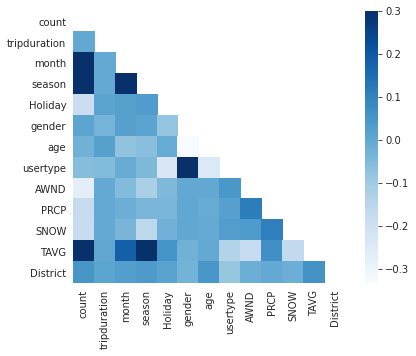

In [ ]:
mask = np.zeros_like(corrMatrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corrMatrix, mask=mask, vmax=.3, square=True, cmap='Blues')

> From correlation heat map, it can be observed that month, season and temperature average have higher correlation compared to trip counts. Snow, pricipitation and wind speed follow. These factors are considered in regression model in later section described. Month variable will not be included since it accounts for time sequence.

### Predicting with Models

#### Machine Learning - Trip Counts Prediction

First, we need to sort out useful features and label for machine learning. However, due to our limitation with knowledge of time series analysis using scikit-learn package, the time-related features are temporarily discarded so that simply linear regression models can be applied in this dataset.

#### Machine Learning Dataset Processing

In [ ]:
# Copy from original dataset
BlueML = Blue19.copy()

In [ ]:
# Select feasible predictors and create dummy variables for categorical variables
BlueML_pre = pd.get_dummies(BlueML[['tripduration', 'starttime', 'month', 'season', 'Holiday', 'gender', 'age', 'AWND', 'PRCP',
       'SNOW', 'TAVG', 'District']], drop_first = True)

In [ ]:
# Resample data on a daily basis
BlueML_1 = BlueML_pre.resample('D', on = 'starttime').agg({'tripduration':len, 'Holiday':np.mean,
                  'AWND':np.mean, 'PRCP':np.mean, 'SNOW':np.mean, 'TAVG':np.mean, 
                  'season_spring':np.mean, 'season_summer':np.mean, 'season_winter':np.mean, 
                  'District_Brookline':np.mean, 'District_Cambridge':np.mean,
                  'District_Everett':np.mean, 'District_Somerville':np.mean})
BlueML_1.columns = ['trip_count', 'Holiday', 'AWND', 'PRCP', 'SNOW', 'TAVG',
            'season_spring', 'season_summer', 'season_winter', 'District_Brookline', 'District_Cambridge',
            'District_Everett', 'District_Somerville']

In [ ]:
# Remove NAs after resampling
BlueML_1 = BlueML_1[BlueML_1['AWND'].notnull()]

In [ ]:
# Import scikit-learn packages
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

##### First Model

According to the correlation analysis, both season and temperature are features having the highest correlation with daily trip counts. So, in the first model, the two features are included to predict daily trip counts.

The rooted mean squared error of the first model is 2,088.75 and the R-squared is 0.66. It turns out that season and temperature have some predictive power but are still not strong enough.

In [ ]:
# First try: Use season and temperature to predict trip counts
X1_df = BlueML_1[['season_spring', 'season_summer', 'season_winter', 'TAVG']]
y1_df = BlueML_1['trip_count']

# Choose 30% of data as testing data
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_df, y1_df, test_size = .3, random_state = 833)

# Fit the linear regression model and predict y_test
model_1 = LinearRegression()
model_1.fit(X1_train, y1_train)
y1_model = model_1.predict(X1_test)

# Calculate mean_squared_error and r^2 score
rmse1 = np.sqrt(mean_squared_error(y1_test, y1_model))
r2_1 = r2_score(y1_test, y1_model)
print('The RMSE is {}.'.format(round(rmse1, 2)))
print('The R2_score is {}.'.format(round(r2_1, 2)))

In [ ]:
# Plot actual y vs. predicted y
sns.relplot(x = y1_test, y = y1_model, kind = 'scatter')
plt.xlabel('Actual Trip Count')
plt.ylabel('Predicted Trip Count')
plt.title('Linear Regression (Actual vs. Predicted)')
plt.plot([0, 14000], [0, 14000], linewidth = 1, c = 'red', linestyle = '--')

##### Second Model

Next, there are other variables also have some correlation with daily tip counts, and it is worth observing if the machine learning model can predict the label better when adding these variables. So, the 'AWND' (average wind speed), 'PRCP' (precipitation), 'SNOW' (snowfall), and 'Holiday' (whether the day is holiday) are included in training the machine learning model to see if we can predict daily trip counts better.

This time, the RMSE decreases to 1,563.58 and the R-squared is 0.81. With other weather features and the 'Holiday' variable, the RMSE and R-squared is greatly improved. Also, when observing the scatter plot of actual testing data and predicted data, the dots are more concentrated to the 45-degree line, which means that the predicted daily trip counts are closer to the actual daily trip counts.

In [ ]:
# Next model: Use season, weather, and holiday features to predict trip counts
X2_df = BlueML_1[['season_spring', 'season_summer', 'season_winter', 'Holiday', 'AWND', 'PRCP', 'SNOW', 'TAVG']]
y2_df = BlueML_1['trip_count']

# Choose 30% of data as testing data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_df, y2_df, test_size = .2, random_state = 833)

# Fit the linear regression model and predict y_test
model_2 = LinearRegression()
model_2.fit(X2_train, y2_train)
y2_model = model_2.predict(X2_test)

# Calculate mean_squared_error and r^2 score
rmse2 = np.sqrt(mean_squared_error(y2_test, y2_model))
r2_2 = r2_score(y2_test, y2_model)
print('The RMSE is {}.'.format(round(rmse2, 2)))
print('The R2_score is {}.'.format(round(r2_2, 2)))

In [ ]:
# Plot actual y vs. predicted y
sns.relplot(x = y2_test, y = y2_model, kind = 'scatter')
plt.xlabel('Actual Trip Count')
plt.ylabel('Predicted Trip Count')
plt.title('Linear Regression (Actual vs. Predicted)')
plt.plot([0, 14000], [0, 14000], linewidth=1, c='red', linestyle='--')

#### Machine Learning - Daily Bike Inflow or Outflow of District

Also, we are interested to know if it is available to use the features in the dataset to predict daily inflow and outflow of bikes in districts. For example, if there are so many bikes outflow from Boston district to Somerville District, then the BLUEbikes company should dispatch more bikes from other districts to Boston in order to make sure its sufficiency.

##### Load Data

In [ ]:
# Load data: Difference Count of bike IDs between those start at District X and those end at District X
BlueReg = pd.read_csv('/content/drive/Shareddrives/MSBA BA 775 Team 1/Bluebikes/Bluereg.csv', index_col = 0);
BlueReg.head()

In [ ]:
# Discard one dummy variable of the same categorical varible to avoid multicollinearity
BlueReg_pre = BlueReg.drop(['District_Somerville', 'season_winter'], axis = 1)

##### Fit the Model

Now, we use weather, season, district, and holiday features to predict the daily bike inflow or outflow of districts. The result turns out that our target variable is not well-explained by our predictors. The RMSE is 18.59 while the R-squared is 0.18. The RMSE seems to be low, but as for this target variable, the standard deviation is only 21.18.
Despite the limitation of our knowledge in more advanced topics of scikit-learn, we suggest that if we can make use of the time-series analysis, we may probably come up with a better result.

In [ ]:
# Select feasible features for LinearRegression
X3_df = BlueReg_pre[['PRCP', 'SNOW', 'TAVG', 'AWND', 'season_spring', 'season_summer', 'season_autumn', 'District_Boston', 
            'District_Brookline', 'District_Cambridge', 'District_Everett', 'Holiday']]
y3_df = BlueReg_pre['Bike Count Difference']

# Choose 30% of data as testing data
X3_train, X3_test, y3_train, y3_test = train_test_split(X3_df, y3_df, test_size = .3, random_state = 833)

# Fit the linear regression model and predict y_test
model_3 = LinearRegression()
model_3.fit(X3_train, y3_train)
y3_model = model_3.predict(X3_test)

# Import mean_squared_error and r^2 score from scikit-learn and calculate
rmse3 = np.sqrt(mean_squared_error(y3_test, y3_model))
r2_3 = r2_score(y3_test, y3_model)
print('The RMSE is {}.'.format(round(rmse3, 2)))
print('The R2_score is {}.'.format(round(r2_3, 2)))

In [ ]:
# Plot actual y vs. predicted y
sns.relplot(x = y3_test, y = y3_model, kind = 'scatter')
plt.xlabel('Actual Trip Count')
plt.ylabel('Predicted Trip Count')
plt.title('Linear Regression (Actual vs. Predicted)')
plt.plot([-100, 100], [-100, 100], linewidth=1, c='red', linestyle='--')
plt.xlim((-120,80))

In [ ]:
# Zoom in to see if there is any pattern
# Plot actual y vs. predicted y
sns.relplot(x = y3_test, y = y3_model, kind = 'scatter')
plt.xlabel('Actual Trip Count')
plt.ylabel('Predicted Trip Count')
plt.title('Linear Regression (Actual vs. Predicted)')
plt.xlim((-30,30))
plt.ylim((-30,30))
plt.plot([-100, 100], [-100, 100], linewidth=1, c='red', linestyle='--')

In [ ]:
# The standard deviation of the target variable
print(round(BlueReg_pre['Bike Count Difference'].std(), 2))

### Conclusion

> From the analysis presented above, it can be concluded that trip counts are affected by seasonal and weather factors such as precipitation, wind speed, snow, and temperature. Whether or not it is a holiday also affects trip counts. From our sklearn LinearRegression model predicting daily trip counts, our model is fairly accurate with given information. 

>However, there exist limitations when attempting to come up with a practice prediction. We mean to predict the hourly difference of each station between the number of pick up bikes and returned bikes, which we can suggest timely allocation of bikes to stations in need. First, variables in datasets are not sufficient enough to explain the reasons for user pickups and returns at one station. There also exists equipment limitation when running too many datasets, RAM space runs when run on Google Colab (we chose to work on Google Colab because the sizes of the dataset are too big, which causes loss of data when transporting, with the only exception of importing and saving dataset on to Google Drive, which can be easily accessed from Google Colab). Most importantly, insufficient knowledge in performing time series prediction refrained us from a more accurate model for the BLUE bikes dataset; therefore, we resided on linear regression.

> There involves further learning and practicing in our technical skills to deliver ideal results. Limitations of this project will be our motivation moving forward.